# The Limits of Machine Learning

## Background

One core problem of contemporary machine learning techniques, as pointed out by [Marcus 2017], [Lake et. al. 2017], and many others, is a lack of symbolic reasoning skills in purely statistically trained ("deep learning" type) models like convolutional neural networks. While [Lake et. al. 2017] propose many possible technological fixes for this problem (for instance, the integration of a game-engine style physics model into a network), we could ask with [Agre 1995] if these fixes do not simply defer an inherently philosophical problem: the problem that, despite neural networks being general function approximators, intelligent generalization can not be modeled with general function approximation. As [Marcus 2017] writes: 

> The real problem lies in misunderstanding what deep learning is, and is not, good for. The technique excels at solving closed-end classification problems, in which a wide range of potential signals must be mapped onto a limited number of categories, given that there is enough data available and the test set closely resembles the training set.
But deviations from these assumptions can cause problems; deep learning is just a statistical technique, and all statistical techniques suffer from deviation from their assumptions.

In other words, "true" generalization would be closer to Cartesian compositionality then to a very large mapping betwen domains. Again [Marcus 2017]:

> [S]ome problems cannot, given real- world limitations, be thought of as classification problems at all. Open-ended natural language understanding, for example, should not be thought of as a classifier mapping between a large finite set of sentences and large, finite set of sentences, but rather a mapping between a potentially infinite range of input sentences and an equally vast array of meanings, many never previously encountered. In a problem like that, deep learning becomes a square peg slammed into a round hole, a crude approximation when there must be a solution elsewhere.

As an illustration of his argument, [Marcus 2017] proposes a toy example: generalizing from even to odd numbers:

> Distilling the broad-ranging problems of language down to a simple example that I believe still has resonance now, I ran a series of experiments in which I trained three- layer perceptrons (fully connected in today’s technical parlance, with no convolution) on the identity function, $f(x) = x$, e.g, $f(12)=12$.

The technical setup for the experiment is simple:

> 1997-vintage networks were, to be sure, simpler than current models — they used no more than three layers (inputs nodes connected to hidden nodes connected to outputs node), and lacked Lecun’s powerful convolution technique. But they were driven by backpropagation just as today’s systems are, and just as beholden to their training data.

The results are straightforward:

> Every time I ran the experiment, using a wide variety of parameters, the results were the same: the network would (unless it got stuck in local minimum) correctly apply the identity function to the even numbers that it had seen before (say 2, 4, 8 and 12), and to some other even numbers (say 6 and 14) but fail on all the odds numbers, yielding, for example f(15) = 14. [...] Odd numbers were outside the training space, and the networks could not generalize identity outside that space. Adding more hidden units didn’t help, and nor did adding more hidden layers. Simple multilayer perceptrons simply couldn’t generalize outside their training space [...].

In the following, we will reproduce the experiment described in [Marcus:2017]. The intention behind this is not so much the validation of their results but an excercise in critical technical practice ([Agre 1997]), in translating between philosophical and technical contexts. Additionally, given the availability of tools compared to 1997, we can implement some simple variations of the proposed experiment and potentially show that the results still hold. 

## Imports
To be able to use mechanisms like differentiation and backpropagation we need a high-level library that abstracts these mathematical details away from us. We are using Keras, the de-facto standard for high-level prototyping for machine learning. Keras is a front-end to the Tensorflow framework, which is one of the ost widely used machine learning frameworks (for a comparison, see machine learning frameworks). Because we are operating in high-dimensional vectir space (and because Keras/Tensorflow use its datatypes), we are also using Numpy, the Python library for scientific computing. Finally, we are importing a single helper function from Scipy to split our data into train and test sets, and some helper functions to plot our activation functions.

In [24]:
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt

## Settings

These constants are the hyperparameters for our neural network. Exactly as proposed by [Marcus 2017], we are implementing the identity function $f(x) = x$ for binary integers. Our parameters are:

- Our integers have `BITS` bits, so our network should learn to apply the identify function for $\frac{2^{16}}{2}$ possible *even* integers.
- After training we will test our network on `VAL` validation samples that are kept back.
- Our hidden layers consist of `HIDDEN` units each.
- We use `LAYERS` layers total.
- We train the network for `EPOCHS` "epochs". One epoch is a complete "run" of all available training samples, i.e. a single forward and backward pass with all available samples.
- We pass the samples to the network in batches of `BATCHES` each, this saves memory.
- We do integrate some dropout layers to prevent overfitting (particularly important in this case).
- Finally we "mix in" `MIX` odd numbers into our even numbers to find the threshold that enables the network to generalize for even and odd numbers.

In [42]:
BITS = 16
VAL = 25
HIDDEN = 128
LAYERS = 3
EPOCHS = 100
BATCHES = 128
DROPOUT = False
MIX = 0

## Function to approximate

We define the most simple function possible, the identity function $f(x) = x$. To allow some additional experiments, we also define the bitwise-not function, $f(x)=\sim{x}$. Note that the numpy implementation of bitwise not returns an array of truth values. To convert this into an array of 0s and 1s, we simply multiply it by 1.

In [43]:
def f(x):
    
    # Identity
    return x
    
    # Bitwise not
    # return  np.logical_not(x) * 1

## Creating the training data

Our training data is simple: a set of binary values, encoded as `BITS` dimensional vectors (e.g. `[0, 0, 1, 1, 1]`), provides both the input and desired output of our network. To produce this set, we create two two-dimensional arrays (`x_even` and `x_odd`) that will hold the even and odd numbers, respectively. We then fill the arrays from the bottom up, by iterating over the range of all $2^{\text{BITS}}$ possible numbers with a step width of 2. In each step, we write the current number to the array that holds the even numbers, and the current number minus one to the array that holds the odd numbers. We randomly shuffle both arrays, and reserve a part for testing, and another (smaller) part for validation. Finally, we apply the function defined above to a copy of the array of even numbers, and use this as the target.

In [44]:
MAX = 2**BITS # BITS bits = 2^BITS values

# Make space for all even BITS-bit numbers and all odd BITS-bit numbers
x_even = np.zeros((int(MAX/2), BITS), dtype=int)
x_odd = np.zeros((int(MAX/2), BITS), dtype=int)

# Fill from the bottom, converting to binary on the fly
for i in range(0, MAX, 2):
    x_even[int(i/2),:] = np.array(list(np.binary_repr(i, BITS)))
    x_odd[int(i/2),:] = np.array(list(np.binary_repr(i+1, BITS)))

# Randomly shuffle everything    
np.random.shuffle(x_even)
np.random.shuffle(x_odd)

x_val_even = x_even[-VAL:,:] # Save last VAL random even numbers for prediction 
x_even = x_even[:-VAL,:] # (use the rest for training and testing)
x_val_odd = x_odd[-VAL:,:] # Save last VAL random odd numbers for prediction (throw the rest away)

x_even[:MIX,:] = x_odd[:MIX,:]
# Randomly shuffle again   
np.random.shuffle(x_even)

# Apply function we would like to model
y = f(x_even)

# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
x_train, x_test, y_train, y_test = train_test_split(x_even, y, test_size=0.1, random_state=42)

print(str(BITS) + ' bit numbers = ' + str(MAX) + ' possible values.')
print("Train set: " + str(len(x_train)) + ' even binary vectors (' + str(MIX) + ' odd mixed into total set).')
print("Test set: " + str(len(x_test)) + ' even binary vectors (' + str(MIX) + ' odd mixed into total set).')
print("Validation set: " + str(len(x_val_even)) + ' even binary vectors and ' + str(len(x_val_odd)) + ' odd binary vectors.')

16 bit numbers = 65536 possible values.
Train set: 29468 even binary vectors (0 odd mixed into total set).
Test set: 3275 even binary vectors (0 odd mixed into total set).
Validation set: 25 even binary vectors and 25 odd binary vectors.


## Building the model

Keras conveniently provides us with abstractions for many of the most commonly used building blocks of neural networks. For this experiment, we are using six different components: fully connected layers, ReLu activation, a sigmoid activation, a binary cross-entropy loss function, and backporpagation by means of stochastic gradient descent.

### Fully connected layer

This is the standard, multilayer perceptron layer, where every unit of a layer is connected to every unit of the layer before and after. 

### ReLu activation function

[Rectified linear units](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) are the most popular neural network units at the time of writing. Despite their "linear look", the [activation function](https://en.wikipedia.org/wiki/Activation_function) used: 

$$f(x)=\max(0,x)$$

is actually nonlinear ([piecewise-linear](https://en.wikipedia.org/wiki/Piecewise_linear_function), to be precise) *and* differentiable. Why nonlinear? Well, a linear function has to satisfy the condition 

$$\forall_{x,y}: f(x) + f(y) = f(x+y)$$

For ReLu, 

$$f(-1) = -1$$
$$f(1) = 1$$
$$f(0) = 0$$ 

Its derivative is then simply 

$$f'(x)={\begin{cases}0&{\text{for }}x<0\\1&{\text{for }}x\geq 0\end{cases}}$$

Interestingly, the "almost-linearity" of ReLus does not impede their universality in approximating functions (see [these examples](https://www.quora.com/Is-a-single-layered-ReLu-network-still-a-universal-approximator/answer/Conner-Davis-2)).

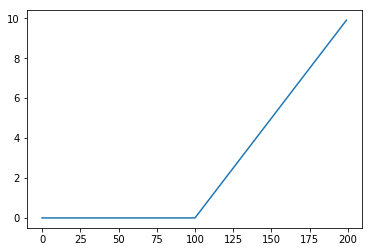

In [45]:
plt.plot([max(0, x) for x in np.arange(-10.0,10.0,0.1)])
plt.show()

### Sigmoid activation function

The [sigmoid function](https://en.wikipedia.org/wiki/Logistic_function), also called logistic function, looks roughly like the simple step function but has non-zero gradients everywhere, which makes it fully differentiable. It is defined as

$$f(x)={\frac {1}{1+e^{-x}}}$$

with the derivative

$$f'(x)=f(x)(1-f(x))$$

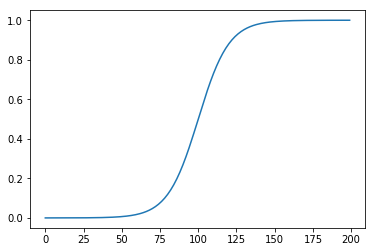

In [46]:
plt.plot([sigmoid(x) for x in np.arange(-10.0,10.0,0.1)])
plt.show()

### Binary cross-entopy loss function

Because our input and output are binary numbers, we are dealing with a [multi-label classification]( https://en.wikipedia.org/wiki/Multi-label_classification) problem. The loss function best suited to address this scenario is binary [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy). In mathematical terms, minimizing this function equals minimizing the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), here the divergence of the probability distribution inherent in the training set and the probability distribution created by the model.

### Backpropagation via stochastic gradient descent

First, a quick derivative reminder:

$$\frac{df}{dx} = \lim_{x \to +\infty} \frac{f(x+h)-f(x)}{h}$$

[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is based on the observation that if the multi-variable function $f(x)$ is defined and differentiable in a neighborhood of a point $a$, then $f(x)$ decreases fastest if one goes from $a$ in the direction of the negative gradient of $f$ at $a$, $f(a) -\nabla f(a)$. The algorithm for a system with the loss function $Loss$ would then be

$$w_n \leftarrow w_n - \underbrace{\eta}_\text{step size} \nabla_{w_{n}} Loss(w_n)$$

for every training sample, where $\nabla_{w_{n}}$ ([Del](https://en.wikipedia.org/wiki/Del)) denotes the partial derivative w. r. t. the weight $w_n$, which can usually be derived by means of the [chain rule](https://en.wikipedia.org/wiki/Chain_rule): 

$$(f\circ g)'=(f'\circ g)\cdot g'$$

[Stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) adds an additional element to the process to increase throughput: batch size. Instead of supplying one training sample per iteration (where iteration defines one forward and backward pass), multiple (random) samples are concatenated and the network is trained on these concatenated "mini-batches". Essentially, we are trading dimensionality for speed which is intuitively a good choice if we use GPUs for training.

Example: $f(x)=x^4−3x^3+2$, with derivative $f'(x)=4x3−9x^2$

In [47]:
# From calculation, it is expected that the local minimum occurs at x=9/4

x = 6 # The algorithm starts at x=6
eta = 0.01 # Step size multiplier
precision = 0.00001
previous_step_size = 1/precision # Some large value

df = lambda x: 4 * x**3 - 9 * x**2

while previous_step_size > precision:
    prev_x = x
    x += -eta * df(prev_x)
    previous_step_size = abs(x - prev_x)

print("The local minimum occurs at " + str(x))

The local minimum occurs at 2.2499646074278457


In [48]:
model = Sequential()
# Dense(HIDDEN) is a fully-connected layer with HIDDEN hidden units.
# In the first layer, you must specify the expected input data shape, here BITS-dimensional vectors.
model.add(layers.Dense(HIDDEN, activation='relu', input_dim=BITS))
for _ in range(LAYERS-1):
    model.add(layers.Dense(HIDDEN, activation='relu'))
    if (DROPOUT): model.add(layers.Dropout(0.5))
# Sigmoid activation for multilabel classification
# https://github.com/keras-team/keras/issues/741
# https://en.wikipedia.org/wiki/Multi-label_classification
model.add(layers.Dense(BITS, activation='sigmoid'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# Binary crossentropy for multilabel classification
# https://github.com/keras-team/keras/issues/741
# https://en.wikipedia.org/wiki/Multi-label_classification
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 16)                2064      
Total params: 37,264
Trainable params: 37,264
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [49]:
model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCHES)
score = model.evaluate(x_test, y_test, batch_size=128)

Epoch 1/100
29468/29468 [==============================] - 1s 17us/step - loss: 0.6400 - acc: 0.6730
Epoch 2/100
29468/29468 [==============================] - 0s 14us/step - loss: 0.5009 - acc: 0.8781
Epoch 3/100
29468/29468 [==============================] - 0s 12us/step - loss: 0.2921 - acc: 0.9504
Epoch 4/100
29468/29468 [==============================] - 0s 11us/step - loss: 0.1247 - acc: 0.9933
Epoch 5/100
29468/29468 [==============================] - 0s 11us/step - loss: 0.0493 - acc: 0.9998
Epoch 6/100
29468/29468 [==============================] - 0s 11us/step - loss: 0.0248 - acc: 1.0000
Epoch 7/100
29468/29468 [==============================] - 0s 11us/step - loss: 0.0156 - acc: 1.0000
Epoch 8/100
29468/29468 [==============================] - 0s 11us/step - loss: 0.0111 - acc: 1.0000
Epoch 9/100
29468/29468 [==============================] - 0s 13us/step - loss: 0.0084 - acc: 1.0000
Epoch 10/100
29468/29468 [==============================] - 0s 11us/step - loss: 0.0067 - a

29468/29468 [==============================] - 0s 12us/step - loss: 1.9676e-04 - acc: 1.0000
Epoch 80/100
29468/29468 [==============================] - 0s 12us/step - loss: 1.9307e-04 - acc: 1.0000
Epoch 81/100
29468/29468 [==============================] - 0s 12us/step - loss: 1.8951e-04 - acc: 1.0000
Epoch 82/100
29468/29468 [==============================] - 0s 14us/step - loss: 1.8604e-04 - acc: 1.0000
Epoch 83/100
29468/29468 [==============================] - 0s 13us/step - loss: 1.8271e-04 - acc: 1.0000
Epoch 84/100
29468/29468 [==============================] - 0s 12us/step - loss: 1.7946e-04 - acc: 1.0000
Epoch 85/100
29468/29468 [==============================] - 0s 12us/step - loss: 1.7632e-04 - acc: 1.0000
Epoch 86/100
29468/29468 [==============================] - 0s 12us/step - loss: 1.7326e-04 - acc: 1.0000
Epoch 87/100
29468/29468 [==============================] - 0s 12us/step - loss: 1.7030e-04 - acc: 1.0000
Epoch 88/100
29468/29468 [==============================] -

## Evaluating the model

We are now using the samples that we kept back to evaulate how well our model has learned to approximate the identity function. First, we define some "pretty printing" options, then we let our model make predictions and compare the evaluation samples with the outputs of the prediction, digit by digit.

In [50]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

x_pred_even = np.rint(model.predict(x_val_even)).astype(np.uint8)
x_pred_odd = np.rint(model.predict(x_val_odd)).astype(np.uint8)

print('EVEN\n')
for y in range(VAL):
    for x in range(BITS):
        if f(x_val_even)[y, x] == x_pred_even[y, x]:
            print(colors.ok + str(x_pred_even[y, x]) + colors.close, end=' ')
        else:
            print(colors.fail + str(x_pred_even[y, x]) + colors.close, end=' ')
    # https://stackoverflow.com/questions/41069825/convert-binary-01-numpy-to-integer-or-binary-string#41069967
    print(x_pred_even[y,:].dot(2**np.arange(x_pred_even[y,:].size)[::-1]))

print('\nODD\n')
for y in range(VAL):
    for x in range(BITS):
        if f(x_val_odd)[y, x] == x_pred_odd[y, x]:
            print(colors.ok + str(x_pred_odd[y, x]) + colors.close, end=' ')
        else:
            print(colors.fail + str(x_pred_odd[y, x]) + colors.close, end=' ')
    # https://stackoverflow.com/questions/41069825/convert-binary-01-numpy-to-integer-or-binary-string#41069967
    print(x_pred_odd[y,:].dot(2**np.arange(x_pred_odd[y,:].size)[::-1]))

EVEN

1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 61452
1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 44972
1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 41062
1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 43160
0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 7888
1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 60178
0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 8778
1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 35216
0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 5390
1 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 45300
0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 28258
0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 15020
0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 28824
0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 23066
0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 590
0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 11784
0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 7104
1 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 43702
1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 63304
1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 48336
0 1 0 1 1 1 1 1 1 0 0 1 0 0 1 0 24466
1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 58768
1 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 51794
0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 4196
1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 34782

ODD

1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 35140
1 0 0 0

## Bibliography

- Agre, Philip E. *Computation and Human Experience*. Cambridge University Press, 1997.
- Agre, Philip E. "The Soul Gained and Lost. Artificial Intelligence as a Philosophical Project." Stanford Humanities Review 4, no. 2 (1995): 1–19.
- Hornik, Kurt, Maxwell Stinchcombe, and Halbert White. "Multilayer Feedforward Networks Are Universal Approximators." Neural Networks 2, no. 5 (1989): 359–66.
- Lake, Brenden M., Tomer D. Ullman, Joshua B. Tenenbaum, and Samuel J. Gershman. "Building Machines That Learn and Think Like People." Behavioral and Brain Sciences 40 (2017).
- Marcus, Gary. "Deep Learning: A Critical Appraisal." arXiv Preprint arXiv:1801.00631, 2018. https://arxiv.org/abs/1801.00631v1.